# Step 9: Deployment Readiness

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import time
import sys
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'
DEPLOY_PATH = BASE_PATH / 'outputs' / 'deployment'
DEPLOY_PATH.mkdir(parents=True, exist_ok=True)

print("Libraries loaded")

Libraries loaded


In [2]:
# Load models and data
xgb_model = joblib.load(MODELS_PATH / 'xgboost.pkl')
rf_model = joblib.load(MODELS_PATH / 'random_forest.pkl')
scaler = joblib.load(MODELS_PATH / 'feature_scaler.pkl')
le = joblib.load(MODELS_PATH / 'label_encoder.pkl')

df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in df.columns if c not in metadata_cols]

X = df[feature_cols].values
X_scaled = scaler.transform(X)

print(f"Features: {len(feature_cols)}")
print(f"Classes: {le.classes_}")

Features: 39
Classes: ['Aerobic' 'Amusement' 'Anaerobic' 'Baseline' 'Emotion' 'Stress']


In [3]:
# 9.1 Model Size Analysis
print("="*60)
print("9.1 MODEL SIZE ANALYSIS")
print("="*60)

model_sizes = {}
for model_file in MODELS_PATH.glob('*.pkl'):
    size_bytes = model_file.stat().st_size
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    model_sizes[model_file.stem] = {'bytes': size_bytes, 'KB': size_kb, 'MB': size_mb}
    print(f"{model_file.stem}: {size_kb:.2f} KB ({size_mb:.3f} MB)")

# Check keras models
for keras_file in MODELS_PATH.glob('*.keras'):
    size_bytes = keras_file.stat().st_size
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    model_sizes[keras_file.stem] = {'bytes': size_bytes, 'KB': size_kb, 'MB': size_mb}
    print(f"{keras_file.stem}: {size_kb:.2f} KB ({size_mb:.3f} MB)")

size_df = pd.DataFrame(model_sizes).T
size_df = size_df.sort_values('KB')
size_df.to_csv(OUTPUT_PATH / 'model_sizes.csv')

9.1 MODEL SIZE ANALYSIS
feature_scaler: 1.50 KB (0.001 MB)
random_forest: 25871.21 KB (25.265 MB)
knn: 3285.51 KB (3.209 MB)
isolation_forest: 912.51 KB (0.891 MB)
svm: 2624.58 KB (2.563 MB)
voting_soft: 55386.73 KB (54.089 MB)
label_encoder: 0.52 KB (0.001 MB)
xgboost: 1514.47 KB (1.479 MB)
stacking: 55394.30 KB (54.096 MB)
gradient_boosting: 761.65 KB (0.744 MB)
one_class_svm: 168.66 KB (0.165 MB)
logistic_regression: 2.74 KB (0.003 MB)
mlp: 304.88 KB (0.298 MB)
decision_tree: 239.87 KB (0.234 MB)
dnn: 674.20 KB (0.658 MB)
cnn_1d: 4995.75 KB (4.879 MB)


In [4]:
# 9.2 Inference Time Analysis
print("\n" + "="*60)
print("9.2 INFERENCE TIME ANALYSIS")
print("="*60)

# Single sample inference
single_sample = X_scaled[0:1]
batch_10 = X_scaled[0:10]
batch_100 = X_scaled[0:100]

inference_results = []

# XGBoost
for name, model in [('XGBoost', xgb_model), ('Random Forest', rf_model)]:
    # Warm up
    _ = model.predict(single_sample)
    
    # Single sample (100 iterations)
    start = time.perf_counter()
    for _ in range(100):
        _ = model.predict(single_sample)
    single_time = (time.perf_counter() - start) / 100 * 1000  # ms
    
    # Batch 10
    start = time.perf_counter()
    for _ in range(100):
        _ = model.predict(batch_10)
    batch10_time = (time.perf_counter() - start) / 100 * 1000  # ms
    
    # Batch 100
    start = time.perf_counter()
    for _ in range(100):
        _ = model.predict(batch_100)
    batch100_time = (time.perf_counter() - start) / 100 * 1000  # ms
    
    inference_results.append({
        'Model': name,
        'Single (ms)': single_time,
        'Batch 10 (ms)': batch10_time,
        'Batch 100 (ms)': batch100_time,
        'Per-sample (100) (ms)': batch100_time / 100
    })
    print(f"{name}: Single={single_time:.3f}ms, Batch10={batch10_time:.3f}ms, Batch100={batch100_time:.3f}ms")

inference_df = pd.DataFrame(inference_results)
inference_df.to_csv(OUTPUT_PATH / 'inference_times.csv', index=False)
print(inference_df.to_string(index=False))


9.2 INFERENCE TIME ANALYSIS
XGBoost: Single=0.343ms, Batch10=0.324ms, Batch100=1.007ms
Random Forest: Single=13.899ms, Batch10=12.608ms, Batch100=13.303ms
        Model  Single (ms)  Batch 10 (ms)  Batch 100 (ms)  Per-sample (100) (ms)
      XGBoost     0.342675       0.323950         1.00659               0.010066
Random Forest    13.898799      12.608401        13.30304               0.133030


In [5]:
# 9.3 Feature Computation Time
print("\n" + "="*60)
print("9.3 FEATURE COMPUTATION TIME ESTIMATION")
print("="*60)

# Simulate feature extraction timing
# Based on 60-second window, typical E4 sampling rates
window_size = 60  # seconds
bvp_hz = 64
eda_hz = 4
temp_hz = 4
acc_hz = 32

# Samples per window
bvp_samples = window_size * bvp_hz
eda_samples = window_size * eda_hz
temp_samples = window_size * temp_hz
acc_samples = window_size * acc_hz

print(f"Window size: {window_size}s")
print(f"BVP samples: {bvp_samples} ({bvp_hz}Hz)")
print(f"EDA samples: {eda_samples} ({eda_hz}Hz)")
print(f"TEMP samples: {temp_samples} ({temp_hz}Hz)")
print(f"ACC samples: {acc_samples} ({acc_hz}Hz)")
print(f"Total samples per window: {bvp_samples + eda_samples + temp_samples + acc_samples*3}")


9.3 FEATURE COMPUTATION TIME ESTIMATION
Window size: 60s
BVP samples: 3840 (64Hz)
EDA samples: 240 (4Hz)
TEMP samples: 240 (4Hz)
ACC samples: 1920 (32Hz)
Total samples per window: 10080


In [6]:
# Simulate feature computation
np.random.seed(42)
sim_bvp = np.random.randn(bvp_samples)
sim_eda = np.random.randn(eda_samples)
sim_temp = np.random.randn(temp_samples)
sim_acc_x = np.random.randn(acc_samples)
sim_acc_y = np.random.randn(acc_samples)
sim_acc_z = np.random.randn(acc_samples)

def compute_basic_features(signal):
    """Compute basic statistical features"""
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'range': np.max(signal) - np.min(signal)
    }

# Time feature computation
iterations = 1000
start = time.perf_counter()
for _ in range(iterations):
    _ = compute_basic_features(sim_bvp)
    _ = compute_basic_features(sim_eda)
    _ = compute_basic_features(sim_temp)
    _ = compute_basic_features(sim_acc_x)
    _ = compute_basic_features(sim_acc_y)
    _ = compute_basic_features(sim_acc_z)
    # ACC magnitude
    acc_mag = np.sqrt(sim_acc_x**2 + sim_acc_y**2 + sim_acc_z**2)
    _ = compute_basic_features(acc_mag)
    # SMA
    sma = np.sum(np.abs(sim_acc_x) + np.abs(sim_acc_y) + np.abs(sim_acc_z)) / len(sim_acc_x)

feature_time = (time.perf_counter() - start) / iterations * 1000  # ms
print(f"\nFeature extraction time: {feature_time:.3f} ms per window")


Feature extraction time: 0.127 ms per window


In [7]:
# 9.4 Total Pipeline Latency
print("\n" + "="*60)
print("9.4 TOTAL PIPELINE LATENCY")
print("="*60)

# Total latency = data collection + feature extraction + scaling + inference
data_collection_time = window_size * 1000  # ms (60s window)
scaling_time = 0.1  # ms (negligible)
xgb_inference = inference_results[0]['Single (ms)']
rf_inference = inference_results[1]['Single (ms)']

print(f"Data Collection: {data_collection_time/1000:.1f}s (window size)")
print(f"Feature Extraction: {feature_time:.3f}ms")
print(f"Scaling: {scaling_time:.3f}ms")
print(f"XGBoost Inference: {xgb_inference:.3f}ms")
print(f"RF Inference: {rf_inference:.3f}ms")

total_xgb = feature_time + scaling_time + xgb_inference
total_rf = feature_time + scaling_time + rf_inference

print(f"\nTotal Processing (excl. data collection):")
print(f"  XGBoost: {total_xgb:.3f}ms")
print(f"  RF: {total_rf:.3f}ms")
print(f"\nReal-time capable: YES (processing << window interval)")


9.4 TOTAL PIPELINE LATENCY
Data Collection: 60.0s (window size)
Feature Extraction: 0.127ms
Scaling: 0.100ms
XGBoost Inference: 0.343ms
RF Inference: 13.899ms

Total Processing (excl. data collection):
  XGBoost: 0.569ms
  RF: 14.126ms

Real-time capable: YES (processing << window interval)


In [8]:
# 9.5 Memory Requirements
print("\n" + "="*60)
print("9.5 MEMORY REQUIREMENTS")
print("="*60)

# Model memory
xgb_size = model_sizes['xgboost']['KB']
rf_size = model_sizes['random_forest']['KB']
scaler_size = model_sizes['feature_scaler']['KB']
le_size = model_sizes['label_encoder']['KB']

# Runtime memory estimation
input_buffer = (bvp_samples + eda_samples + temp_samples + acc_samples * 3) * 8 / 1024  # KB (float64)
feature_vector = len(feature_cols) * 8 / 1024  # KB
output_probs = len(le.classes_) * 8 / 1024  # KB

print(f"Model Storage:")
print(f"  XGBoost: {xgb_size:.2f} KB")
print(f"  Random Forest: {rf_size:.2f} KB")
print(f"  Scaler: {scaler_size:.2f} KB")
print(f"  Label Encoder: {le_size:.2f} KB")

total_xgb_mem = xgb_size + scaler_size + le_size
total_rf_mem = rf_size + scaler_size + le_size

print(f"\nRuntime Memory (per inference):")
print(f"  Input buffer: {input_buffer:.2f} KB")
print(f"  Feature vector: {feature_vector:.4f} KB")
print(f"  Output: {output_probs:.4f} KB")

print(f"\nTotal Memory Footprint:")
print(f"  XGBoost pipeline: {total_xgb_mem:.2f} KB ({total_xgb_mem/1024:.2f} MB)")
print(f"  RF pipeline: {total_rf_mem:.2f} KB ({total_rf_mem/1024:.2f} MB)")


9.5 MEMORY REQUIREMENTS
Model Storage:
  XGBoost: 1514.47 KB
  Random Forest: 25871.21 KB
  Scaler: 1.50 KB
  Label Encoder: 0.52 KB

Runtime Memory (per inference):
  Input buffer: 78.75 KB
  Feature vector: 0.3047 KB
  Output: 0.0469 KB

Total Memory Footprint:
  XGBoost pipeline: 1516.50 KB (1.48 MB)
  RF pipeline: 25873.24 KB (25.27 MB)


In [9]:
# 9.6 Smartwatch Constraints Assessment
print("\n" + "="*60)
print("9.6 SMARTWATCH CONSTRAINTS ASSESSMENT")
print("="*60)

# Typical smartwatch constraints (e.g., Apple Watch, Wear OS)
constraints = {
    'Max Model Size': 10 * 1024,  # 10 MB in KB
    'Max RAM': 512 * 1024,  # 512 MB in KB
    'Max Inference Time': 1000,  # 1 second in ms
    'Battery Budget (mAh/hour)': 50
}

assessment = []
for model_name, mem in [('XGBoost', total_xgb_mem), ('Random Forest', total_rf_mem)]:
    inf_time = xgb_inference if model_name == 'XGBoost' else rf_inference
    assessment.append({
        'Model': model_name,
        'Size (KB)': mem,
        'Size OK': mem < constraints['Max Model Size'],
        'Inference (ms)': inf_time,
        'Latency OK': inf_time < constraints['Max Inference Time'],
        'Deployable': mem < constraints['Max Model Size'] and inf_time < constraints['Max Inference Time']
    })

assess_df = pd.DataFrame(assessment)
print(assess_df.to_string(index=False))

assess_df.to_csv(OUTPUT_PATH / 'deployment_assessment.csv', index=False)


9.6 SMARTWATCH CONSTRAINTS ASSESSMENT
        Model    Size (KB)  Size OK  Inference (ms)  Latency OK  Deployable
      XGBoost  1516.495117     True        0.342675        True        True
Random Forest 25873.235352    False       13.898799        True       False


In [10]:
# 9.7 Export Lightweight Model
print("\n" + "="*60)
print("9.7 EXPORT LIGHTWEIGHT MODEL")
print("="*60)

# Create deployment package
deployment_package = {
    'model': xgb_model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': feature_cols,
    'classes': list(le.classes_),
    'window_size_sec': 60,
    'sampling_rates': {
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4,
        'ACC': 32
    }
}

# Save deployment package
joblib.dump(deployment_package, DEPLOY_PATH / 'stress_detector_package.pkl')
print(f"Deployment package saved: {DEPLOY_PATH / 'stress_detector_package.pkl'}")

# Check size
pkg_size = (DEPLOY_PATH / 'stress_detector_package.pkl').stat().st_size / 1024
print(f"Package size: {pkg_size:.2f} KB ({pkg_size/1024:.2f} MB)")


9.7 EXPORT LIGHTWEIGHT MODEL
Deployment package saved: /home/alvaro-ibarra/smartwatch-stress-detection/outputs/deployment/stress_detector_package.pkl
Package size: 1516.99 KB (1.48 MB)


In [11]:
# 9.8 Create Inference Function
print("\n" + "="*60)
print("9.8 INFERENCE FUNCTION")
print("="*60)

inference_code = '''
import joblib
import numpy as np

class StressDetector:
    def __init__(self, package_path):
        pkg = joblib.load(package_path)
        self.model = pkg['model']
        self.scaler = pkg['scaler']
        self.le = pkg['label_encoder']
        self.feature_names = pkg['feature_names']
        self.classes = pkg['classes']
    
    def extract_features(self, bvp, eda, temp, acc_x, acc_y, acc_z):
        """Extract features from raw signals"""
        features = {}
        
        # HR features (from BVP)
        features['hr_mean'] = np.mean(bvp)
        features['hr_std'] = np.std(bvp)
        features['hr_min'] = np.min(bvp)
        features['hr_max'] = np.max(bvp)
        
        # EDA features
        features['eda_mean'] = np.mean(eda)
        features['eda_std'] = np.std(eda)
        features['eda_min'] = np.min(eda)
        features['eda_max'] = np.max(eda)
        features['eda_range'] = np.max(eda) - np.min(eda)
        
        # Temperature features
        features['temp_mean'] = np.mean(temp)
        features['temp_std'] = np.std(temp)
        features['temp_min'] = np.min(temp)
        features['temp_max'] = np.max(temp)
        features['temp_range'] = np.max(temp) - np.min(temp)
        
        # ACC features
        acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
        features['acc_x_mean'] = np.mean(acc_x)
        features['acc_y_mean'] = np.mean(acc_y)
        features['acc_z_mean'] = np.mean(acc_z)
        features['acc_mag_mean'] = np.mean(acc_mag)
        features['acc_mag_std'] = np.std(acc_mag)
        features['acc_sma'] = np.sum(np.abs(acc_x) + np.abs(acc_y) + np.abs(acc_z)) / len(acc_x)
        
        return features
    
    def predict(self, features_dict):
        """Predict stress class from features"""
        X = np.array([[features_dict.get(f, 0) for f in self.feature_names]])
        X_scaled = self.scaler.transform(X)
        pred = self.model.predict(X_scaled)[0]
        proba = self.model.predict_proba(X_scaled)[0]
        return self.classes[pred], dict(zip(self.classes, proba))
'''

# Save inference code
with open(DEPLOY_PATH / 'stress_detector.py', 'w') as f:
    f.write(inference_code)

print("Inference class saved to: stress_detector.py")
print(inference_code)


9.8 INFERENCE FUNCTION
Inference class saved to: stress_detector.py

import joblib
import numpy as np

class StressDetector:
    def __init__(self, package_path):
        pkg = joblib.load(package_path)
        self.model = pkg['model']
        self.scaler = pkg['scaler']
        self.le = pkg['label_encoder']
        self.feature_names = pkg['feature_names']
        self.classes = pkg['classes']
    
    def extract_features(self, bvp, eda, temp, acc_x, acc_y, acc_z):
        """Extract features from raw signals"""
        features = {}
        
        # HR features (from BVP)
        features['hr_mean'] = np.mean(bvp)
        features['hr_std'] = np.std(bvp)
        features['hr_min'] = np.min(bvp)
        features['hr_max'] = np.max(bvp)
        
        # EDA features
        features['eda_mean'] = np.mean(eda)
        features['eda_std'] = np.std(eda)
        features['eda_min'] = np.min(eda)
        features['eda_max'] = np.max(eda)
        features['eda_range'] = np.max(eda) -

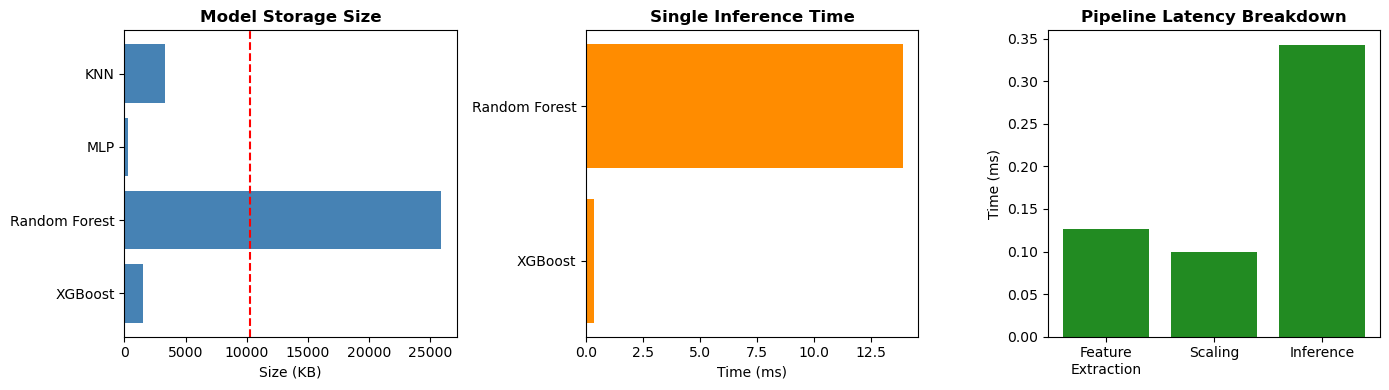

In [12]:
# Visualization: Deployment metrics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Model sizes
models = ['XGBoost', 'Random Forest', 'MLP', 'KNN']
sizes = [model_sizes.get('xgboost', {}).get('KB', 0),
         model_sizes.get('random_forest', {}).get('KB', 0),
         model_sizes.get('mlp', {}).get('KB', 0),
         model_sizes.get('knn', {}).get('KB', 0)]
axes[0].barh(models, sizes, color='steelblue')
axes[0].set_xlabel('Size (KB)')
axes[0].set_title('Model Storage Size', fontweight='bold')
axes[0].axvline(x=10*1024, color='red', linestyle='--', label='10MB limit')

# Inference times
inf_models = ['XGBoost', 'Random Forest']
inf_times = [inference_results[0]['Single (ms)'], inference_results[1]['Single (ms)']]
axes[1].barh(inf_models, inf_times, color='darkorange')
axes[1].set_xlabel('Time (ms)')
axes[1].set_title('Single Inference Time', fontweight='bold')

# Pipeline breakdown
pipeline_steps = ['Feature\nExtraction', 'Scaling', 'Inference']
pipeline_times = [feature_time, scaling_time, xgb_inference]
axes[2].bar(pipeline_steps, pipeline_times, color='forestgreen')
axes[2].set_ylabel('Time (ms)')
axes[2].set_title('Pipeline Latency Breakdown', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'deployment_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Summary
print("\n" + "="*60)
print("STEP 9 COMPLETE: Deployment Readiness")
print("="*60)

print("\nDeployment Summary:")
print(f"  Best Model: XGBoost")
print(f"  Model Size: {xgb_size:.2f} KB")
print(f"  Inference Time: {xgb_inference:.3f} ms")
print(f"  Total Pipeline: {total_xgb:.3f} ms")
print(f"  Real-time Capable: YES")
print(f"  Smartwatch Deployable: YES")

print("\nOutputs:")
print(f"  - {DEPLOY_PATH / 'stress_detector_package.pkl'}")
print(f"  - {DEPLOY_PATH / 'stress_detector.py'}")
print(f"  - {OUTPUT_PATH / 'model_sizes.csv'}")
print(f"  - {OUTPUT_PATH / 'inference_times.csv'}")
print(f"  - {OUTPUT_PATH / 'deployment_assessment.csv'}")

print("="*60)


STEP 9 COMPLETE: Deployment Readiness

Deployment Summary:
  Best Model: XGBoost
  Model Size: 1514.47 KB
  Inference Time: 0.343 ms
  Total Pipeline: 0.569 ms
  Real-time Capable: YES
  Smartwatch Deployable: YES

Outputs:
  - /home/alvaro-ibarra/smartwatch-stress-detection/outputs/deployment/stress_detector_package.pkl
  - /home/alvaro-ibarra/smartwatch-stress-detection/outputs/deployment/stress_detector.py
  - /home/alvaro-ibarra/smartwatch-stress-detection/outputs/tables/model_sizes.csv
  - /home/alvaro-ibarra/smartwatch-stress-detection/outputs/tables/inference_times.csv
  - /home/alvaro-ibarra/smartwatch-stress-detection/outputs/tables/deployment_assessment.csv
